<a href="https://colab.research.google.com/github/ajinkyabhanudas/SIADS696/blob/dev/EDA_Ajinkya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook works on the first step of the train pipeline: data loading 
- The idea is to use the contents of this notebook as a makefile target so it can be the first step to run as we keep populating our datastore.








In [1]:
!git clone https://github.com/ajinkyabhanudas/SIADS696.git
!pip install gensim==4.1.2

Cloning into 'SIADS696'...
remote: Enumerating objects: 578, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 578 (delta 14), reused 25 (delta 6), pack-reused 473
Receiving objects: 100% (578/578), 41.31 MiB | 14.58 MiB/s, done.
Resolving deltas: 100% (317/317), done.
Checking out files: 100% (164/164), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 15.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import datetime
import enum
import glob
import json
import os
import re
from itertools import groupby

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore')

In [3]:
import gensim.downloader
glove_wv = gensim.downloader.load('glove-wiki-gigaword-50')
nltk.download('punkt')
nltk.download('stopwords')

[==================================================] 100.0% 66.0/66.0MB downloaded


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
try:
  os.chdir('SIADS696')
except:
  print("You're either already in the SIADS696 directory, or the path specified isn't accessible")

### We'll extract our dataset in two parts:
- first extract the overall stats data per channel and store it along with the channel name instead of the id for available channels. (`overall_stats_raw_df`)
- And second, extract the per-video data into another dataframe. (`raw_df`)

In [5]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories', 'topicLabel']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        temp_dict["topicLabel"] = path.split('/')[2]
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

### Next, let's do a quick check on the data and take a quick look at the data in both the dfs

In [6]:
raw_df.info()
raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      55337 non-null  object
 1   title            55337 non-null  object
 2   channelId        55124 non-null  object
 3   description      55124 non-null  object
 4   channelTitle     55124 non-null  object
 5   tags             51972 non-null  object
 6   categoryId       55124 non-null  object
 7   viewCount        55050 non-null  object
 8   likeCount        54589 non-null  object
 9   favoriteCount    55121 non-null  object
 10  commentCount     54549 non-null  object
 11  duration         55125 non-null  object
 12  definition       55125 non-null  object
 13  contentRating    55125 non-null  object
 14  topicCategories  54331 non-null  object
 15  topicLabel       55337 non-null  object
dtypes: object(16)
memory usage: 6.8+ MB


,publishedAt,title,channelId,description,channelTitle,tags,categoryId,viewCount,likeCount,favoriteCount,commentCount,duration,definition,contentRating,topicCategories,topicLabel
20431,2016-12-04T00:38:12Z,Get You A Girl That Can Do Both (ft. Gina Rodr...,UCfm4y4rHF5HGrSr-qbvOwOg,WATCH THE BLOOPERS: http://bit.ly/2g5VYVZ\nWAT...,Lilly Singh,"[iisuperwomanii, iisuperwomenii, superwoman, s...",23,6966646,334053,0,8572,PT6M23S,hd,{},"[https://en.wikipedia.org/wiki/Entertainment, ...",Comedy
3044,2017-08-01T13:00:02Z,Binging with Babish: Zelda - Breath of the Wild,UCJHA_jMfCvEnv-3kRjTCQXw,"Pre-order my first cookbook, Eat What You Watc...",Babish Culinary Universe,"[baked apples recipe, zelda baked apples, zeld...",24,6130486,143756,0,7363,PT7M39S,hd,{},"[https://en.wikipedia.org/wiki/Food, https://e...",Cooking
44522,2017-01-18T17:34:54Z,Make Up Tutorial: Daytime smokey purple eyesha...,UCI9s9nFu2m3K2CvhO2QVfTg,Products used: \nEyelid primer: http://amzn.to...,Candace Cabrera,"[yoga, yoga channel, yogabycandace]",24,3049,79,0,21,PT4M44S,hd,{},[https://en.wikipedia.org/wiki/Lifestyle_(soci...,Yoga
5366,2019-11-13T17:00:03Z,Claire & Brad Make the Perfect Thanksgiving Pi...,UCbpMy0Fg74eXXkvxJrtEn3w,Claire Saffitz and Brad Leone know that after ...,Bon Appétit,"[pecan pie, pie, pies, pumpkin pie, thanksgivi...",26,4745435,85948,0,6123,PT46M17S,hd,{},"[https://en.wikipedia.org/wiki/Food, https://e...",Cooking
27561,2020-01-24T11:26:06Z,Why is Italy swinging to the far right? - BBC ...,UC16niRr50-MSBwiO3YDb3RA,"Italy’s far right leader, Matteo Salvini, is h...",BBC News,"[bbc, bbc news, news]",25,185426,2344,0,2088,PT8M39S,hd,{},"[https://en.wikipedia.org/wiki/Politics, https...",News


In [7]:
overall_stats_raw_df.info()
overall_stats_raw_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   viewCount        149 non-null    object
 1   subscriberCount  149 non-null    object
 2   videoCount       149 non-null    object
 3   channelName      149 non-null    object
dtypes: object(4)
memory usage: 4.8+ KB


,viewCount,subscriberCount,videoCount,channelName
11,514689466,3410000,1572,SAM THE COOKING GUY
107,24185621112,53500000,140,EminemMusic
13,1656635427,6110000,1360,Bon Appétit
132,33502127,325000,731,Tara Stiles : Yoga that Feels Like You
104,506269055,5530000,267,minutephysics


### Let's examine our datatypes and convert them appropriately

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   publishedAt      55337 non-null  object
 1   title            55337 non-null  object
 2   channelId        55124 non-null  object
 3   description      55124 non-null  object
 4   channelTitle     55124 non-null  object
 5   tags             51972 non-null  object
 6   categoryId       55124 non-null  object
 7   viewCount        55050 non-null  object
 8   likeCount        54589 non-null  object
 9   favoriteCount    55121 non-null  object
 10  commentCount     54549 non-null  object
 11  duration         55125 non-null  object
 12  definition       55125 non-null  object
 13  contentRating    55125 non-null  object
 14  topicCategories  54331 non-null  object
 15  topicLabel       55337 non-null  object
dtypes: object(16)
memory usage: 6.8+ MB


In [9]:
raw_df.loc[0].publishedAt

'2022-09-29T16:00:30Z'

In [10]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
### Miles code fix included here   
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


# duration_2_secs("PT51M12S")

In [11]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [12]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list



In [13]:
text_prep("i if happening")

['happening']

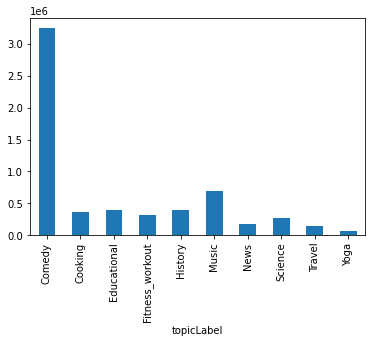

In [14]:
raw_df.groupby('topicLabel').viewCount.agg('median').plot(kind='bar');

In [20]:
# raw_df.topicLabel.map(dict(raw_df.groupby('topicLabel').avg_viewCount.agg('median')))

In [16]:
def cat_stats(df):
  df["publishedAt"] = pd.to_datetime(df.publishedAt)
  df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
  df['publishedDayDelta'] = (datetime.datetime.now() - df.publishedAt.dt.tz_localize(None)).dt.days
  df["viewCount"] = df.viewCount.astype(float)
  df["avg_viewCount"] = df["viewCount"]/df['publishedDayDelta']
  df['topicLabel'] = df.topicLabel.str.lower()
  df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'
  
  return(df.groupby('topicLabel').avg_viewCount.describe())


In [17]:
cat_stats(raw_df).to_csv("cat_stats.csv")

In [18]:
pd.read_csv("cat_stats.csv")

,topicLabel,count,mean,std,min,25%,50%,75%,max
0,comedy,5250.0,5158.141607,15023.181771,3.530101,890.347845,2220.680111,4992.800875,5.270915e+05
1,cooking,7739.0,1388.643498,3038.321217,0.000000,87.131708,296.538682,1310.562570,7.691557e+04
2,educational,5814.0,1710.482542,5858.477005,0.250000,82.919504,333.481508,1143.565415,1.427337e+05
3,fitness,5198.0,2134.939709,12200.864518,0.000000,81.551046,268.833403,806.432501,4.901129e+05
4,history,4298.0,1602.625523,5546.350701,0.000000,186.283314,580.799614,1478.433662,2.205059e+05
5,music,3896.0,11475.101057,83503.859409,0.000000,210.793819,664.605028,3505.614135,2.783838e+06
6,news,7118.0,2681.271035,6152.525870,0.271375,226.206641,753.705213,2447.572570,1.087819e+05
7,science,4762.0,1569.977198,5594.275281,0.148346,34.740486,169.225989,841.033147,1.153705e+05
8,travel,5104.0,1001.487402,5040.451632,0.020423,19.545631,93.251200,542.391722,2.913744e+05
9,yoga,5871.0,1334.392760,11237.957903,0.173938,9.320986,41.434116,314.308906,4.931410e+05


In [19]:
def create_dataset(df, featureset, primary=True):

  if primary:
    df["publishedAt"] = pd.to_datetime(df.publishedAt)
    df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df['publishedDayDelta'] = (datetime.datetime.now() - df.publishedAt.dt.tz_localize(None)).dt.days
    df["categoryId"] = df.categoryId.astype(float)
    df["viewCount"] = df.viewCount.astype(float)
    df["avg_viewCount"] = df["viewCount"]/df['publishedDayDelta']
    df["likeCount"] = df.likeCount.astype(float)
    df["favoriteCount"] = df.favoriteCount.astype(float)
    df["commentCount"] = df.commentCount.astype(float)
    df['duration_secs'] = df.duration.apply(duration_2_secs)
    df['topicCategories'] = df.topicCategories.apply(topic_extract)
    df['primary_cat'] = df.topicCategories.apply(topic_extract)
    df['tags'] = df.tags.apply(topic_extract)
    df['channelTitle'] = df.channelTitle.str.lower()
    df['topicLabel'] = df.topicLabel.str.lower()
    # df['description'] = df.description.apply(text_prep)
    df['title'] = df.title.apply(text_prep)
    df['len_title'] = df.title.apply(lambda x: len(x))
    df['log_duration_secs'] = np.log(df.duration_secs+1)
    df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'
    df['score'] = df["avg_viewCount"]/df.topicLabel.map(dict(df.groupby('topicLabel').avg_viewCount.agg('median')))
  
  else:
    df['ov_viewCount'] = df.viewCount.astype(float)
    df['ov_subscriberCount'] = df.subscriberCount.astype(float)
    df['ov_videoCount'] = df.videoCount.astype(float)
    df['channelName'] = df.channelName.str.lower()

  return df[featureset]

- It's best to drop tags because, in many cases, the tags tend to contain the channel names, which could as we speculated earlier, lead to data leaks.
- We'll also drop channelId because it is visually unintuitve and we can encode the channelNames with simple Id's if we needed to.
- since we don't have data in the order of millions, we'd abstract out the publishing data to a new variable of `publishedDayNum` that contains the day of the year the video was published.
- on examining `contentRating` values, the dataset in non-null but majorly contains empty dictionaries, which makes it misleading. As a result, we'll drop this feature too.
- on examining `favoriteCount` values, the dataset in non-null but majorly contains a value of `0`, which makes it misleading. As a result, we'll drop it.

- dropped columns list [`tags`, `channelId`, `contentRating`] and [`publishedAt`] after deriving the `publishedDayNum` column from it.

In [17]:
features = ['title', 'channelTitle',
 'categoryId', 'viewCount', 'avg_viewCount', 'likeCount',
 'commentCount', 'duration_secs', 'log_duration_secs',
 'definition', 'topicCategories', 'publishedDayNum',
 'publishedDayDelta', 'len_title', 'topicLabel', 'score']

preproc1_df = create_dataset(raw_df, features)

In [18]:
preproc1_df.sample(5)

,title,description,channelTitle,categoryId,viewCount,avg_viewCount,likeCount,commentCount,duration_secs,log_duration_secs,definition,topicCategories,publishedDayNum,publishedDayDelta,len_title,topicLabel,score
11661,"[things, north, korea]","[subscribe, daily, travel, videos, url, join, ...",drew binsky,19.0,9671822.0,9740.002014,153977.0,10825.0,216.0,5.379897,hd,"[society, tourism]",26,993,3,travel,104.138687
6631,"[live, april, finding, resilience, together, l...","[today, ekhartyoga, class, lisa, petersen, fir...",ekhartyoga,26.0,4082.0,4.545657,118.0,17.0,2142.0,7.669962,hd,[lifestyle_(sociology)],121,898,9,yoga,0.109352
42674,"[battlestorm, stalingrad, e, chaos, eve]","[eve, great, attack, stalingrad, city, hoth, s...",tikhistory,27.0,154308.0,167.362256,3708.0,400.0,2003.0,7.602900,hd,"[strategy_video_game, video_game_culture]",97,922,5,history,0.286558
25175,"[unbeetable, olympic, advantage]","[click, tweet, url, always, told, eat, vegetab...",asapscience,28.0,423904.0,113.708155,3071.0,328.0,110.0,4.709530,hd,[knowledge],213,3728,3,science,0.660630
6718,"[egyptian, sun, prayers, salute, earth]","[class, goes, two, flowing, yoga, sequences, e...",ekhartyoga,17.0,9928.0,6.267677,257.0,10.0,955.0,6.862758,hd,[lifestyle_(sociology)],165,1584,5,yoga,0.150778


### Let's try engineering a few more features out of our semi-processed dataset

- a single primary topic to help with the intercept
- median views calculation grouped by primary topics


In [19]:
preproc1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55337 entries, 0 to 55336
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              55337 non-null  object 
 1   description        55337 non-null  object 
 2   channelTitle       55124 non-null  object 
 3   categoryId         55124 non-null  float64
 4   viewCount          55050 non-null  float64
 5   avg_viewCount      55050 non-null  float64
 6   likeCount          54589 non-null  float64
 7   commentCount       54549 non-null  float64
 8   duration_secs      55337 non-null  float64
 9   log_duration_secs  55337 non-null  float64
 10  definition         55125 non-null  object 
 11  topicCategories    54331 non-null  object 
 12  publishedDayNum    55337 non-null  int64  
 13  publishedDayDelta  55337 non-null  int64  
 14  len_title          55337 non-null  int64  
 15  topicLabel         55337 non-null  object 
 16  score              550

Let's again take a look at what percentage of data is missing across all the fields.

In [20]:
missing_data_perc_cols = (preproc1_df.isna().sum()/len(preproc1_df))*100
missing_data_perc_cols

title                0.000000
description          0.000000
channelTitle         0.384914
categoryId           0.384914
viewCount            0.518640
avg_viewCount        0.518640
likeCount            1.351718
commentCount         1.424002
duration_secs        0.000000
log_duration_secs    0.000000
definition           0.383107
topicCategories      1.817952
publishedDayNum      0.000000
publishedDayDelta    0.000000
len_title            0.000000
topicLabel           0.000000
score                0.518640
dtype: float64

In [21]:
lost_rows_perc = len(preproc1_df.dropna())/len(preproc1_df)*100
lost_rows_perc

96.27916222418996

It's under 5% in across all cases, which isn't a bad thing at all and we can easily consider dropping the missing fields as we would regularly keep enriching our datastore, which would easily compensate for the missing 5% over time.

In [22]:
preproc2_df = preproc1_df.dropna()

In [23]:
preproc2_df.isna().sum()

title                0
description          0
channelTitle         0
categoryId           0
viewCount            0
avg_viewCount        0
likeCount            0
commentCount         0
duration_secs        0
log_duration_secs    0
definition           0
topicCategories      0
publishedDayNum      0
publishedDayDelta    0
len_title            0
topicLabel           0
score                0
dtype: int64

In [24]:
preproc2_df.drop('categoryId', axis=1).describe()

,viewCount,avg_viewCount,likeCount,commentCount,duration_secs,log_duration_secs,publishedDayNum,publishedDayDelta,len_title,score
count,5.327800e+04,5.327800e+04,5.327800e+04,5.327800e+04,53278.000000,53278.000000,53278.000000,53278.000000,53278.000000,53278.000000
mean,3.158608e+06,2.802095e+03,4.917423e+04,3.022889e+03,791.403938,6.176761,182.144131,1524.481681,6.011243,9.561663
std,4.565088e+07,2.432102e+04,2.824296e+05,1.263771e+04,1497.323859,0.946581,103.481357,1151.105369,2.538819,103.964258
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,14.000000,0.000000,0.000000
25%,8.738600e+04,7.921441e+01,1.695000e+03,1.290000e+02,238.000000,5.476464,93.000000,550.000000,4.000000,0.281786
50%,3.206290e+05,3.770993e+02,7.418000e+03,5.265000e+02,482.000000,6.180017,183.000000,1317.000000,6.000000,1.009392
75%,1.322312e+06,1.603889e+03,2.816250e+04,1.916000e+03,865.000000,6.763885,268.000000,2299.000000,8.000000,3.745587
max,5.809870e+09,2.787846e+06,3.042521e+07,1.124865e+06,42901.000000,10.666674,366.000000,6140.000000,19.000000,12466.418890


In [25]:
q1, q3 = np.percentile(preproc2_df.score,[25,75])
iqr = q3-q1
ul = q3+1.5*iqr

In [26]:
np.mean(preproc2_df.score>ul)

0.136942077405308

In [27]:
def outlier_thresh(df):
  q1, q3 = np.percentile(df,[25,75])
  iqr = q3-q1
  
  return(q3+1.5*iqr)

In [28]:
topic_thresh_dict = dict(preproc2_df.drop('categoryId', axis=1).groupby('topicLabel').score.apply(outlier_thresh))

we will now eliminate outliers that are above our thresholds to make our data more well-behaved

In [29]:
np.mean(preproc2_df.score>preproc2_df.topicLabel.map(topic_thresh_dict))

0.12708810390780434

we stand to lose, ~13% of our data. since we would keep enriching our database regularly, on average, the data lost at this step would start to become insignificant if the law of large numbers is obeyed.

In [30]:
preproc2_df = preproc2_df[preproc2_df.score<preproc2_df.topicLabel.map(topic_thresh_dict)]

In [31]:
preproc2_df.drop('categoryId', axis=1).corr()

,viewCount,avg_viewCount,likeCount,commentCount,duration_secs,log_duration_secs,publishedDayNum,publishedDayDelta,len_title,score
viewCount,1.000000,0.749807,0.793462,0.678686,-0.064761,-0.074145,0.012103,0.233428,-0.149274,0.261932
avg_viewCount,0.749807,1.000000,0.698382,0.548113,-0.009516,-0.023223,0.030758,-0.124529,-0.067073,0.447020
likeCount,0.793462,0.698382,1.000000,0.798754,-0.055388,-0.033574,0.016994,0.122362,-0.175088,0.199307
commentCount,0.678686,0.548113,0.798754,1.000000,-0.037259,-0.010643,0.012745,0.135257,-0.166049,0.136409
duration_secs,-0.064761,-0.009516,-0.055388,-0.037259,1.000000,0.674693,-0.008336,-0.105854,0.095999,0.065550
log_duration_secs,-0.074145,-0.023223,-0.033574,-0.010643,0.674693,1.000000,-0.011394,-0.163954,0.101223,0.140251
publishedDayNum,0.012103,0.030758,0.016994,0.012745,-0.008336,-0.011394,1.000000,-0.026025,-0.007413,0.003585
publishedDayDelta,0.233428,-0.124529,0.122362,0.135257,-0.105854,-0.163954,-0.026025,1.000000,-0.189122,-0.159740
len_title,-0.149274,-0.067073,-0.175088,-0.166049,0.095999,0.101223,-0.007413,-0.189122,1.000000,0.064401
score,0.261932,0.447020,0.199307,0.136409,0.065550,0.140251,0.003585,-0.159740,0.064401,1.000000


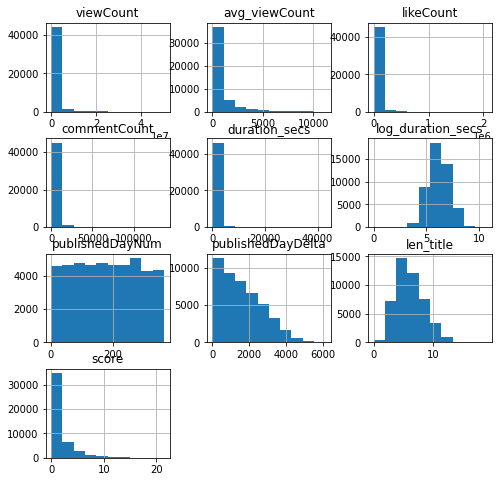

In [32]:
preproc2_df.drop('categoryId', axis=1).hist(figsize=(8,8));

We could consider applying a transformation to the data, to help address the heavy left-skew on most numerical features.

Let's quickly set the same steps up for the `overall_stats_raw_df` df.

In [33]:
overall_stats_raw_df.head()

,viewCount,subscriberCount,videoCount,channelName
0,25940400818,47500000,189,Taylor Swift
1,16361943575,28700000,4705,Ultra Music
2,24185621112,53500000,140,EminemMusic
3,17679529109,35500000,97,Bruno Mars
4,28214976991,52400000,256,Ed Sheeran


In [34]:
overall_stats_raw_df.dtypes

viewCount          object
subscriberCount    object
videoCount         object
channelName        object
dtype: object

In [35]:
ov_features = ['channelName', 'ov_viewCount', 'ov_subscriberCount', 'ov_videoCount']
ov_stats_pre_df1 = create_dataset(overall_stats_raw_df, ov_features, primary=False)

In [36]:
ov_stats_pre_df1.head()

,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,taylor swift,2.594040e+10,47500000.0,189.0
1,ultra music,1.636194e+10,28700000.0,4705.0
2,eminemmusic,2.418562e+10,53500000.0,140.0
3,bruno mars,1.767953e+10,35500000.0,97.0
4,ed sheeran,2.821498e+10,52400000.0,256.0


In [37]:
ov_stats_pre_df1.isna().sum()

channelName           0
ov_viewCount          0
ov_subscriberCount    0
ov_videoCount         0
dtype: int64

With both the datasets ready and a basic relation overview amongst the features, we can now move onto the phase of text processing to make it machine interpretable.

In [38]:
df = pd.merge(preproc2_df, ov_stats_pre_df1, how='left', left_on='channelTitle', right_on='channelName')
df.head()

,title,description,channelTitle,categoryId,viewCount,avg_viewCount,likeCount,commentCount,duration_secs,log_duration_secs,...,topicCategories,publishedDayNum,publishedDayDelta,len_title,topicLabel,score,channelName,ov_viewCount,ov_subscriberCount,ov_videoCount
0,"[well, short, film, official, trailer]","[november, remember, pre, order, red, taylor, ...",taylor swift,10.0,1643008.0,4776.186047,202969.0,13636.0,1860.0,7.528869,...,[entertainment],309,344,5,music,7.066714,taylor swift,2.594040e+10,47500000.0,189.0
1,"[taylor, swift, willow, moonlit, witch, versio...","[official, video, taylor, swift, performing, w...",taylor swift,10.0,906193.0,1358.610195,33802.0,1452.0,209.0,5.347108,...,"[independent_music, music, pop_music]",352,667,8,music,2.010162,taylor swift,2.594040e+10,47500000.0,189.0
2,"[taylor, swift, willow, dancing, witch, versio...","[official, video, taylor, swift, performing, w...",taylor swift,10.0,420666.0,630.683658,26327.0,1556.0,185.0,5.225747,...,"[independent_music, music, pop_music]",352,667,8,music,0.933142,taylor swift,2.594040e+10,47500000.0,189.0
3,"[taylor, swift, willow, lonely, witch, version...","[official, video, taylor, swift, performing, w...",taylor swift,10.0,527496.0,790.848576,22811.0,1034.0,188.0,5.241747,...,"[independent_music, music, pop_music]",352,667,8,music,1.170118,taylor swift,2.594040e+10,47500000.0,189.0
4,"[taylor, swift, willow, yule, log]","[official, video, taylor, swift, performing, w...",taylor swift,10.0,658523.0,987.290855,47099.0,3405.0,215.0,5.375278,...,"[independent_music, music, pop_music]",352,667,5,music,1.460768,taylor swift,2.594040e+10,47500000.0,189.0


In [39]:
# df.loc[df['topicLabel'] == 'fitness_workout', 'topicLabel'] = 'fitness'

In [40]:
df.columns

Index(['title', 'description', 'channelTitle', 'categoryId', 'viewCount',
       'avg_viewCount', 'likeCount', 'commentCount', 'duration_secs',
       'log_duration_secs', 'definition', 'topicCategories', 'publishedDayNum',
       'publishedDayDelta', 'len_title', 'topicLabel', 'score', 'channelName',
       'ov_viewCount', 'ov_subscriberCount', 'ov_videoCount'],
      dtype='object')

In [41]:
# df['std_viewCount'] = df.groupby('channelTitle').viewCount.apply(lambda x: (x - x.mean()) / x.std()).values


In [42]:
# unique_topics_list = set()
# for topic_list in df.topicCategories.values:
#   for topic in topic_list:
#     unique_topics_list.add(topic)

# unique_titles_word_list = set()
# for topic_list in df.title.values:
#   for topic in topic_list:
#     unique_titles_word_list.add(topic)

In [43]:
# unique_titles_word_list

In [44]:
# df = pd.read_csv('SIADS696/df.csv')

In [45]:
basic_model_features = ['title', 'definition', 'publishedDayNum', 'log_duration_secs', 'len_title', 'topicLabel', 'score']
basic_model_data = df[basic_model_features]

basic_model_data.head()

,title,definition,publishedDayNum,log_duration_secs,len_title,topicLabel,score
0,"[well, short, film, official, trailer]",hd,309,7.528869,5,music,7.066714
1,"[taylor, swift, willow, moonlit, witch, versio...",hd,352,5.347108,8,music,2.010162
2,"[taylor, swift, willow, dancing, witch, versio...",hd,352,5.225747,8,music,0.933142
3,"[taylor, swift, willow, lonely, witch, version...",hd,352,5.241747,8,music,1.170118
4,"[taylor, swift, willow, yule, log]",hd,352,5.375278,5,music,1.460768


In [46]:
basic_model_data.topicLabel.unique()

array(['music', 'yoga', 'travel', 'cooking', 'science', 'fitness',
       'educational', 'history', 'news', 'comedy'], dtype=object)

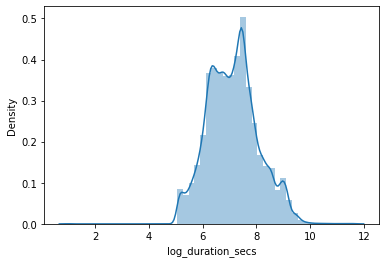

In [47]:
import seaborn as sns
sns.distplot(basic_model_data.log_duration_secs+1);

In [48]:
def gen_word_vec(df_text_list, model):
    word_vector = []
    for token in df_text_list:
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in model.index_to_key]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(model[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(model.vector_size))
    word_vector = np.array(word_vector)
    return np.mean(word_vector, axis=0)

In [49]:
gen_word_vec(['hello'], glove_wv)

array([ 0.0083718 ,  0.92501605,  0.82671994,  0.93556607,  0.146684  ,
       -0.168484  ,  0.505932  , -1.061296  , -0.402934  ,  0.15173168,
        0.0078584 ,  0.623798  , -0.43779   , -0.765722  , -0.16506639,
       -0.4667066 , -0.45821556,  0.05511599, -0.319368  , -0.19256799,
       -0.301969  , -0.728646  ,  0.5106972 ,  0.49465004, -0.096302  ,
       -0.1163846 , -0.18508   , -0.22964561, -0.010829  , -0.1917308 ,
        2.22204   ,  0.0796242 ,  0.00325879,  0.736529  , -0.20064358,
       -0.68017995,  0.4949978 , -0.772092  ,  0.3979736 ,  0.372428  ,
        1.225998  , -0.2150822 , -0.3142818 , -0.1801152 ,  0.09256861,
        0.34115   ,  0.20036101, -0.237222  ,  0.791966  ,  0.92229205],
      dtype=float32)

In [50]:
gen_word_vec(["hello", "hi"], glove_wv)

array([-0.0228391 ,  0.676468  ,  0.6331542 ,  0.51612055,  0.4432595 ,
       -0.238337  ,  0.4528435 , -0.565578  , -0.531372  ,  0.08265974,
        0.0708867 ,  0.604414  , -0.76509506, -0.67381847,  0.0823393 ,
       -0.0618903 , -0.17809978,  0.0735005 , -0.403335  , -0.3093915 ,
       -0.30702198, -0.4339155 ,  0.6385611 ,  0.46106252,  0.142379  ,
       -0.68949056, -0.499165  , -0.11757531,  0.305153  , -0.4147914 ,
        2.466845  ,  0.24705036, -0.03796561,  0.6097295 , -0.16160129,
       -0.68044996,  0.6111214 , -0.25899848,  0.3421388 ,  0.277349  ,
        0.89228797, -0.2619331 , -0.2981009 ,  0.0330909 ,  0.11631081,
        0.29878   ,  0.07689176, -0.4420785 ,  0.463128  ,  0.95529854],
      dtype=float32)

In [ ]:
titles = basic_model_data.vec_title.apply(pd.Series).rename(columns={i-1:"title_"+str(i) for i in range(1,51)})


In [ ]:
data_df = pd.concat([titles, basic_model_data[['publishedDayNum', 'log_duration_secs', 'score', 'len_title']], pd.get_dummies(basic_model_data.definition), pd.get_dummies(basic_model_data.topicLabel)], axis=1)

In [ ]:
data_df.to_csv("data_df.csv")

In [ ]:
data_df.head()

A new notebook should start here

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
data_train, data_test = train_test_split(data_df, test_size=0.20, random_state=42)

In [ ]:
# data_train["smote_thresh"] = data_train.std_viewCount>=10

In [ ]:
# data_train.smote_thresh.value_counts()
data_train.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,comedy,cooking,educational,fitness,history,music,news,science,travel,yoga
25617,-0.116116,0.805909,0.644511,0.691821,0.489663,0.041699,0.633763,-0.654132,-0.290710,-0.026090,...,0,0,0,1,0,0,0,0,0,0
13989,-0.167959,0.741446,0.540157,0.537544,0.586885,0.092586,0.300925,-0.726261,-0.277708,0.066455,...,0,1,0,0,0,0,0,0,0,0
30199,0.003190,0.756032,0.729363,0.700835,0.360254,0.038062,0.301440,-0.760162,-0.159814,0.013568,...,0,0,1,0,0,0,0,0,0,0
31524,0.032892,0.758939,0.637583,0.775430,0.361579,0.034557,0.299713,-0.861616,-0.192700,0.071812,...,0,0,1,0,0,0,0,0,0,0
44694,-0.023028,0.805909,0.691913,0.735660,0.219330,-0.053332,0.394272,-0.689977,-0.260224,-0.037126,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
data_train = data_train.dropna()

In [ ]:
data_test = data_test.dropna()

In [ ]:
# from imblearn.over_sampling import SMOTE 

In [ ]:
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(data_train.drop("smote_thresh", axis=1), data_train["smote_thresh"])

In [ ]:
# y_res.value_counts()

In [ ]:
train_X = data_train.drop(["score"], axis=1) #X_res.drop("score", axis=1) #data_train.drop(["std_viewCount", "smote_thresh"], axis=1) #use X_res for smote
train_y = data_train.score#X_res.score#data_train.std_viewCount

test_X = data_test.drop("score", axis=1)
test_y = data_test.score

In [ ]:
train_X.head()

,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,...,comedy,cooking,educational,fitness,history,music,news,science,travel,yoga
25617,-0.116116,0.805909,0.644511,0.691821,0.489663,0.041699,0.633763,-0.654132,-0.290710,-0.026090,...,0,0,0,1,0,0,0,0,0,0
13989,-0.167959,0.741446,0.540157,0.537544,0.586885,0.092586,0.300925,-0.726261,-0.277708,0.066455,...,0,1,0,0,0,0,0,0,0,0
30199,0.003190,0.756032,0.729363,0.700835,0.360254,0.038062,0.301440,-0.760162,-0.159814,0.013568,...,0,0,1,0,0,0,0,0,0,0
31524,0.032892,0.758939,0.637583,0.775430,0.361579,0.034557,0.299713,-0.861616,-0.192700,0.071812,...,0,0,1,0,0,0,0,0,0,0
44694,-0.023028,0.805909,0.691913,0.735660,0.219330,-0.053332,0.394272,-0.689977,-0.260224,-0.037126,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# set(X_res.columns)-set(test_X.columns)

In [ ]:
# train_X

In [ ]:
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)



In [ ]:
pca = PCA(n_components=20)
pca.fit(train_X)


PCA(n_components=20)

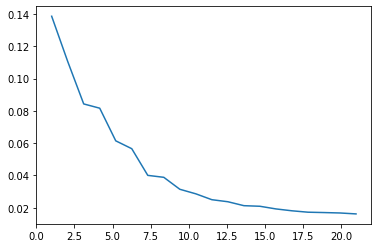

In [ ]:
import matplotlib.pyplot as plt
##SCREE PLOT
plt.plot(np.linspace(1,21,20),pca.explained_variance_ratio_);


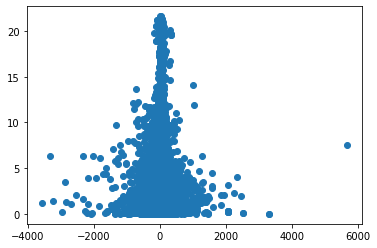

In [ ]:
pca = PCA(n_components=10) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)

plt.scatter(pca_train_X[:,0], train_y);

based on the first PCA, it is clear that the data is not linear and we would have to bear that in mind with the choice of our models

In [ ]:
pca_train_X.shape, train_y.shape

((38133, 10), (38133,))

In [ ]:
pca = PCA(n_components=10) #components based on the scree plot above

pca_train_X = pca.fit_transform(train_X)
pca_test_X = pca.transform(test_X)


The cells below are not the modeling phase of our project, it was primarily used as a run once, and throw away check on the data.

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


In [ ]:
train_X=pca_train_X
test_X=pca_test_X

In [ ]:
# data_train.sample(frac=0.2,replace=True)

In [ ]:
# poly = PolynomialFeatures(3)
# x_poly_train = poly.fit_transform(train_X)
# x_poly_test = poly.transform(test_X)

# train_X = x_poly_train
# test_X = x_poly_test ###uncomment 3 cells above for another test

In [ ]:
lr = LinearRegression()
llr = Lasso(alpha=0.1)
rr = Ridge(alpha=1.0)
dr = DummyRegressor(strategy="mean")
svr = SVR(kernel = 'linear')
dtr = DecisionTreeRegressor(max_depth=20)

lr.fit(train_X, train_y)
llr.fit(train_X, train_y)
rr.fit(train_X, train_y)
dr.fit(train_X, train_y)
# svr.fit(train_X, train_y)
dtr.fit(train_X, train_y)

In [ ]:
lr.score(train_X, train_y)
# cross_val_score(dtr, train_X, train_y, cv=5)

-0.45015632372241976

In [ ]:
lr_pred = lr.predict(test_X)
dr_pred = dr.predict(test_X)
rr_pred = rr.predict(test_X)
svr_pred = svr.predict(test_X)
dtr_pred = dtr.predict(test_X)
llr_pred = llr.predict(test_X)
nn_pred = model.predict(test_X)

298/298 [==============================] - 1s 1ms/step


In [ ]:
# plt.scatter()

In [ ]:
def ret_metrics(test_y, pred):

  mae = metrics.mean_absolute_error(test_y, pred)
  mse = metrics.mean_squared_error(test_y, pred)
  rmse = np.sqrt(mse)

  return(mae, mse, rmse)

In [ ]:
print(f"LR metrics for mae, mse, rmse are: {ret_metrics(test_y, lr_pred)}")
print(f"LLR metrics for mae, mse, rmse are: {ret_metrics(test_y, llr_pred)}")
print(f"DR metrics for mae, mse, rmse are: {ret_metrics(test_y, dr_pred)}")
print(f"RR metrics for mae, mse, rmse are: {ret_metrics(test_y, rr_pred)}")
# print(f"SVR metrics for mae, mse, rmse are: {ret_metrics(test_y, svr_pred)}")
print(f"DTR metrics for mae, mse, rmse are: {ret_metrics(test_y, dtr_pred)}")
print(f"NN metrics for mae, mse, rmse are: {ret_metrics(test_y, nn_pred)}")


LR metrics for mae, mse, rmse are: (1.7588553799937643, 9.381879965314749, 3.062985466063257)
LLR metrics for mae, mse, rmse are: (1.7070496710134206, 6.345125059315302, 2.518953167352522)
DR metrics for mae, mse, rmse are: (1.7067541313412653, 6.3547621676773645, 2.5208653608785543)
RR metrics for mae, mse, rmse are: (1.7071913367598424, 6.345914121045821, 2.5191097874141613)
DTR metrics for mae, mse, rmse are: (1.9157080678780172, 9.932978068829748, 3.15166274668305)
NN metrics for mae, mse, rmse are: (1.4583262540606725, 7.358182536044981, 2.712597009517813)


In [ ]:
preds_df = pd.DataFrame({"true":test_y, "lr":lr_pred, "dr":dr_pred, "rr":rr_pred, "svr":-1, "dtr":dtr_pred, "llr":llr_pred, "nn": nn_pred[:,0]})

In [ ]:
preds_df

,true,lr,dr,rr,svr,dtr,llr,nn
14802,0.080764,-0.016760,1.766782,1.750022,-1,1.161643,1.750017,0.766650
36376,0.758520,-0.018717,1.766782,1.748065,-1,1.766222,1.748382,0.615064
25220,0.943855,-0.110610,1.766782,1.656172,-1,1.246115,1.657820,0.545203
42510,2.302350,0.022699,1.766782,1.789481,-1,1.766222,1.788978,0.834347
1640,0.712014,0.000132,1.766782,1.766914,-1,1.766222,1.767185,0.807090
...,...,...,...,...,...,...,...,...
34212,0.117072,-0.041265,1.766782,1.725516,-1,0.626705,1.726151,0.579662
5273,0.203402,0.250357,1.766782,2.017139,-1,0.600409,2.012226,0.634384
32211,4.981957,-0.010655,1.766782,1.756127,-1,1.573673,1.756324,0.726730
32415,2.160767,-0.029369,1.766782,1.737413,-1,0.466215,1.737860,0.635902


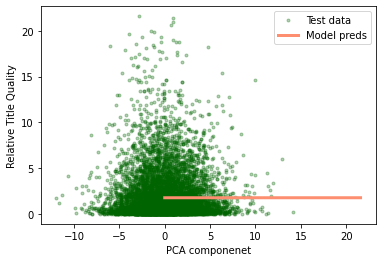

In [ ]:
lists = sorted(zip(*[test_y, dr_pred]))
sorted_x_test, sorted_y_test_pred = list(zip(*lists))
pca_n = 1


# plt.plot(pca_train_X[:,pca_n],train_y,'.',color="darkblue", alpha=0.3,label="Train data")
plt.plot(pca_test_X[:,pca_n],test_y,'.',color='darkgreen', alpha=0.3, label="Test data")
plt.ylabel('Relative Title Quality')
plt.xlabel('PCA componenet')

plt.plot(sorted_x_test,sorted_y_test_pred,color='#FD8E70',linewidth=3, label="Model preds")

plt.legend()
plt.show()